## 利用Apriori算法进行关联分析

- **关联分析的目标**
    1. 发现频繁项集（频繁项集是满足最小支持度要求的项集，它给出经常在一起出现的元素项）
    2. 发现关联规则（关联规则意味着元素项之间“如果…那么…”的关系
- **两个概念**
    1. **支持度support**：数据集中包含该项集的数据所占数据集的比例，度量一个集合在原始数据中出现的频率
    2. **置信度confidence**：是针对一条关联规则来定义的，**a->b的置信度=支持度{a|b}/支持度{a}**，a|b表示ab的并集
- **Apriori原理：**
    1. 如果某个项集是频繁的，那么它的所有子集也是频繁的
    2. 如果某个项集是非频繁的，那么它的所有超集也是非频繁的
    3. 基于此，Apriori算法从单元素项集开始，通过组合满足最小支持度的项集来形成更大的集合
- **Apriori算法缺点**
    1. 每次增加频繁项集大小时(即Ck->Lk时)，算法需要重新扫描整个数据集，当数据集很大时，算法效率很低（解决：FP-Growth算法）

### 1. 用Apriori算法挖掘频繁项集
- 逻辑
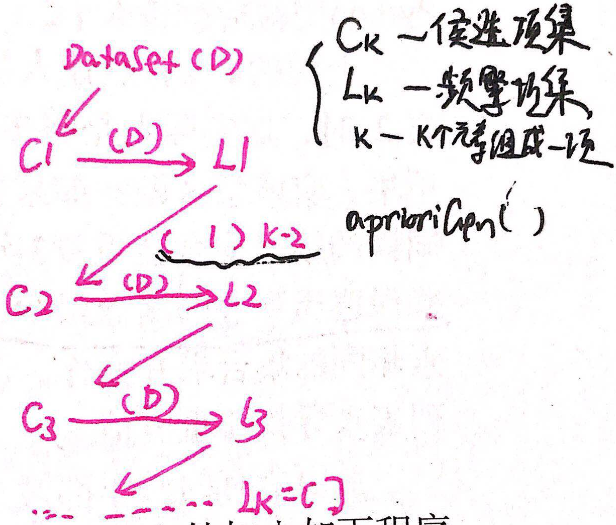

In [1]:
from numpy import *

In [94]:
#加载数据集
def loadDataSet():
    return [[1,3,4],[2,3,5],[1,2,3,5],[2,5]]

#选取数据集的非重复元素组成候选集的集合C1
def createC1(dataSet):
    C1=[]
    for transaction in dataSet: #对数据集中的每条购买记录
        for item in transaction: #对购买记录中的每个元素
            if [item] not in C1: #注意，item外要加上[]，便于与C1中的[item]对比
                C1.append([item])
    C1.sort()
    return list(map(frozenset,C1)) #将C1各元素转换为frozenset格式，注意frozenset作用对象为可迭代对象

#由Ck产生Lk：扫描数据集D，计算候选集Ck各元素在D中的支持度，选取支持度大于设定值的元素进入Lk
def scanD(D,Ck,minSupport):
    ssCnt={}
    for tid in D: #对数据集中的每条购买记录
        for can in Ck: #遍历Ck所有候选集
            if can.issubset(tid): #如果候选集包含在购买记录中，计数+1
                ssCnt[can]=ssCnt.get(can,0)+1
    numItems=float(len(D)) #购买记录数
    retList=[] #用于存放支持度大于设定值的项集
    supportData={} #用于记录各项集对应的支持度
    for key in ssCnt.keys():
        support=ssCnt[key]/numItems
        if support>=minSupport:
            retList.insert(0,key)
        supportData[key]=support
    return retList,supportData

In [92]:
#由Lk产生Ck+1
def aprioriGen(Lk,k): #Lk的k和参数k不是同一个概念，Lk的k比参数k小1
    retList=[]
    lenLk=len(Lk)
    for i in range(lenLk):
        for j in range(i+1,lenLk): #比较Lk中的每一个元素与其他元素
            L1=list(Lk[i])[:k-2];L2=list(Lk[j])[:k-2]
            L1.sort();L2.sort()
            if L1==L2: #若前k-2项相同，则合并这两项
                retList.append(Lk[i]|Lk[j])
    return retList

#Apriori算法主函数
def apriori(dataSet,minSupport=0.5):
    C1=createC1(dataSet)
    D=list(map(set,dataSet))
    L1,supportData=scanD(D,C1,minSupport)
    L=[L1]
    k=2
    while len(L[k-2])>0: #当L[k]为空时，停止迭代
        Ck=aprioriGen(L[k-2],k) #L[k-2]对应的值是Lk-1
        Lk,supK=scanD(D,Ck,minSupport)
        supportData.update(supK)
        L.append(Lk)
        k+=1
    return L,supportData

- 测试

In [95]:
dataset=loadDataSet()
C1=createC1(dataset)
D=list(map(set,dataset))
L1,supportData0=scanD(D,C1,0.5)
L1,supportData0

([frozenset({5}), frozenset({2}), frozenset({3}), frozenset({1})],
 {frozenset({1}): 0.5,
  frozenset({3}): 0.75,
  frozenset({4}): 0.25,
  frozenset({2}): 0.75,
  frozenset({5}): 0.75})

In [96]:
L,supportData=apriori(dataset,minSupport=0.5)
L,supportData

([[frozenset({5}), frozenset({2}), frozenset({3}), frozenset({1})],
  [frozenset({2, 3}), frozenset({3, 5}), frozenset({2, 5}), frozenset({1, 3})],
  [frozenset({2, 3, 5})],
  []],
 {frozenset({1}): 0.5,
  frozenset({3}): 0.75,
  frozenset({4}): 0.25,
  frozenset({2}): 0.75,
  frozenset({5}): 0.75,
  frozenset({1, 3}): 0.5,
  frozenset({2, 5}): 0.75,
  frozenset({3, 5}): 0.5,
  frozenset({2, 3}): 0.5,
  frozenset({1, 5}): 0.25,
  frozenset({1, 2}): 0.25,
  frozenset({2, 3, 5}): 0.5})

### 2. 从频繁项集挖掘关联规则
- **规则a->b的置信度=支持度{a|b}/支持度{a}**，a|b表示ab的并集
- 若某条规则不满足最小置信度要求，则该规则的所有子集也不满足最小置信度要求
- 选择置信度大于设定值的规则为关联规则

In [82]:
# 主函数，由频繁项集以及对应的支持度，得到各条规则的置信度，选择置信度满足要求的规则为关联规则
# 为了避免将所有数据都对比一遍，采用与上述相同的逻辑减少计算量——一层一层计算筛选
def generateRules(L,supportData,minConf=0.7):
    bigRuleList=[]
    for i in range(1,len(L)):
        for freqSet in L[i]:
            H1=[frozenset([item]) for item in freqSet] # H1是频繁项集单元素列表，是关联规则中a->b的b项
            if i>1:
                rulesFromConseq(freqSet,H1,supportData,bigRuleList,minConf)
            else:
                calConf(freqSet,H1,supportData,bigRuleList,minConf)
    return bigRuleList

# 置信度计算函数
def calConf(freqSet,H,supportData,brl,minConf=0.7):
    prunedH=[] # 用于存放置信度满足要求的关联规则的b项，即“提纯后的H”
    for conseq in H:
        conf=supportData[freqSet]/supportData[freqSet-conseq]
        if conf>=minConf:
            print (freqSet-conseq,'-->',conseq,'conf:',conf)
            brl.append([freqSet-conseq,conseq,conf])
            prunedH.append(conseq)
    return prunedH

# 关联规则合并函数
def rulesFromConseq(freqSet,H,supportData,brl,minConf=0.7):
    m=len(H[0])
    if len(freqSet)>(m+1): #查看频繁项集freqSet是否大到可以移除大小为m的子集
        Hmp1=aprioriGen(H,m+1) # 从Hm合并Hm+1
        Hmp1=calConf(freqSet,Hmp1,supportData,brl,minConf)
        if len(Hmp1)>1: #若合并后的Hm+1的元素大于1个，则继续合并
            rulesFromConseq(freqSet,Hmp1,supportData,brl,minConf)

- 测试

In [97]:
L,supportData=apriori(dataset,minSupport=0.5)
rules=generateRules(L,supportData,minConf=0.5)

frozenset({3}) --> frozenset({2}) conf: 0.6666666666666666
frozenset({2}) --> frozenset({3}) conf: 0.6666666666666666
frozenset({5}) --> frozenset({3}) conf: 0.6666666666666666
frozenset({3}) --> frozenset({5}) conf: 0.6666666666666666
frozenset({5}) --> frozenset({2}) conf: 1.0
frozenset({2}) --> frozenset({5}) conf: 1.0
frozenset({3}) --> frozenset({1}) conf: 0.6666666666666666
frozenset({1}) --> frozenset({3}) conf: 1.0
frozenset({5}) --> frozenset({2, 3}) conf: 0.6666666666666666
frozenset({3}) --> frozenset({2, 5}) conf: 0.6666666666666666
frozenset({2}) --> frozenset({3, 5}) conf: 0.6666666666666666
